In [1]:
from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree 
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# Reading dataset (from https://www.kaggle.com/datasets/mathchi/diabetes-data-set?resource=download)
diabetes = pd.read_csv('/Users/pauor506/Documents/PP_active_learning/Easy_diabetes_dataset/diabetes.csv')

#### Let's replaces the "non-sense" values with the mean

In [3]:
diabetes['Glucose']=diabetes['Glucose'].replace(0,diabetes['Glucose'].mean())
diabetes['BloodPressure']=diabetes['BloodPressure'].replace(0,diabetes['BloodPressure'].mean())
diabetes['SkinThickness']=diabetes['SkinThickness'].replace(0,diabetes['SkinThickness'].mean())
diabetes['Insulin']=diabetes['Insulin'].replace(0,diabetes['Insulin'].mean())
diabetes['BMI']=diabetes['BMI'].replace(0,diabetes['BMI'].mean())

diabetes.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


## Version 1: using the default data set and train/trst split

In [4]:
X = diabetes.drop(['Outcome'], axis=1).to_numpy() # I am using all the features for prediction
y = diabetes['Outcome'].to_numpy()

In [5]:
# Parameters for ML model
test_size = 0.2
n_neighbours = 3

# Data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=9827)

# Models
knn = KNeighborsClassifier(n_neighbors = n_neighbours)
lrg = LogisticRegression(random_state=0, max_iter=200)
rf = RandomForestClassifier(max_depth=3, random_state=0)
svmm = svm.SVC(random_state=0)
ada_clf = AdaBoostClassifier(random_state=0) #DecisionTreeClassifier initialized with max_depth=1 and 50 trees

In [6]:
f1_scores, accuracies = [], []
models = [knn, lrg, rf, svmm, ada_clf]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1scr = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1_scores.append(f1scr)
    print("The f1-scores of model {} is {:.3f} and the accuracy is {:.3f}".format(model,f1scr,acc))


The f1-scores of model KNeighborsClassifier(n_neighbors=3) is 0.581 and the accuracy is 0.747
The f1-scores of model LogisticRegression(max_iter=200, random_state=0) is 0.659 and the accuracy is 0.805
The f1-scores of model RandomForestClassifier(max_depth=3, random_state=0) is 0.525 and the accuracy is 0.753
The f1-scores of model SVC(random_state=0) is 0.532 and the accuracy is 0.760
The f1-scores of model AdaBoostClassifier(random_state=0) is 0.602 and the accuracy is 0.760


<function matplotlib.pyplot.show(close=None, block=None)>

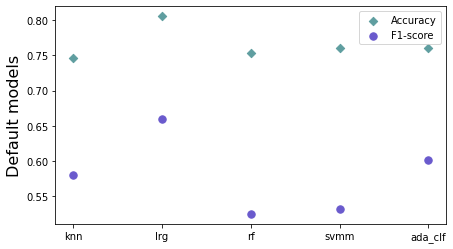

In [7]:
models_names =['knn', 'lrg', 'rf', 'svmm', 'ada_clf']

fig, ax1, = plt.subplots(1,1,figsize=(7,4))
ax1.scatter(np.arange(len(accuracies)), accuracies, marker = 'D', s=35, color='cadetblue')
ax1.scatter(np.arange(len(f1_scores)), f1_scores, marker = 'o', s=55, color='slateblue')

ax1.set_ylabel('F1-score/Accuracy', color = 'black', fontsize = 16)
ax1.set_ylabel('Default models', color = 'black', fontsize = 16)
ax1.legend(['Accuracy', 'F1-score'])
plt.xticks(ticks=np.arange(0,5), labels=models_names)

plt.show



## Version 2: K-fold cross validation

In [18]:
from sklearn.model_selection import cross_validate

# Function to obtain scores from two different metrics
def CV_multiple_metrics(model, _X, _y, _cv,):
    metrics = ['accuracy', 'f1']
    results = cross_validate(estimator = model, X =_X, y =_y, cv = _cv, 
                            scoring = metrics, return_train_score=True)
    return [results['train_accuracy']], [results['train_accuracy'].mean()], [results['train_f1']], [results['train_f1'].mean()]

# Training
def train_x_modelList(models_list, _X, _y, _cv):
    acc_cv_x_model = []
    f1_cv_x_model = []
    for model in models_list:
        _, res_acc, _, res_f1 = CV_multiple_metrics(model, _X, _y, _cv)
        acc_cv_x_model.append(res_acc)
        f1_cv_x_model.append(res_f1)
    
    acc_cv_x_model = [item for sublist in acc_cv_x_model for item in sublist]
    f1_cv_x_model = [item for sublist in f1_cv_x_model for item in sublist]

    return acc_cv_x_model, f1_cv_x_model

# This function plots two lists: accuracy and f1-scores. They must be represented as ONE poin per model
def plotting(_models_names, _accuracies, _f1_scores, title):
    fig, ax1, = plt.subplots(1,1,figsize=(7,6))
    xx = np.arange(len(_accuracies))
    ax1.scatter(xx, _accuracies, marker = 'D', s=35, color='cadetblue')
    ax1.scatter(xx, _f1_scores, marker = 'o', s=55, color='slateblue')

    ax1.set_ylabel('F1-score/Accuracy', color = 'black', fontsize = 16)
    ax1.set_ylabel('Default models', color = 'black', fontsize = 16)
    ax1.legend(['Accuracy', 'F1-score'])
    ax1.set_title(title)

    # Annotating points
    for i, txt in enumerate(["{0:0.2f}".format(i) for i in _accuracies]):
        ax1.annotate(txt, (xx[i], _accuracies[i]-0.015))

    # Annotating points
    for i, txt in enumerate(["{0:0.2f}".format(i) for i in _f1_scores]):
        ax1.annotate(txt, (xx[i], _f1_scores[i]+0.015))

    plt.xticks(ticks=np.arange(0,5), labels=models_names)

    plt.show()

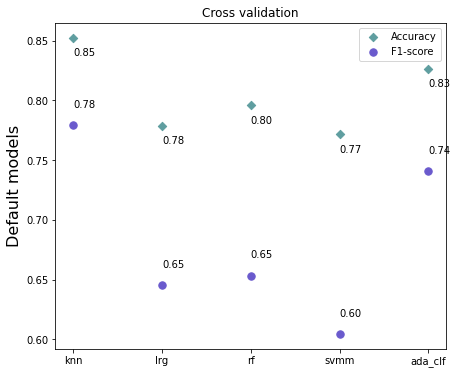

In [19]:
# Training with KFold cross validation
cv_number = 5

kfold_validation=KFold(cv_number)
acc_cv_x_model, f1_cv_x_model = train_x_modelList(models, X, y, kfold_validation)
plotting(models_names, acc_cv_x_model, f1_cv_x_model, 'Cross validation')


## Version 3: Stratified KFold cross validation

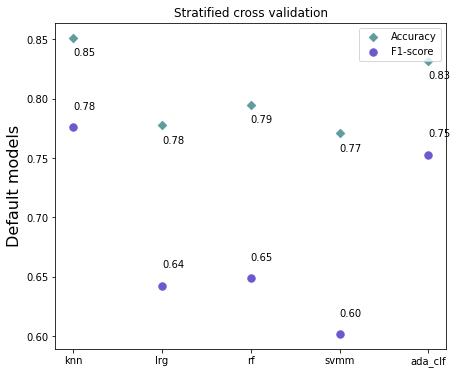

In [20]:
from sklearn.model_selection import StratifiedKFold

sk_fold=StratifiedKFold(n_splits = cv_number)

acc_cv_x_model_str, f1_cv_x_model_str = train_x_modelList(models, X, y, sk_fold)
plotting(models_names, acc_cv_x_model_str, f1_cv_x_model_str, 'Stratified cross validation')